In [31]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [32]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [33]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/vaibes/Downloads/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [34]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [35]:

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


2025-04-13 11:11:03.190122: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-04-13 11:11:03.549318: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


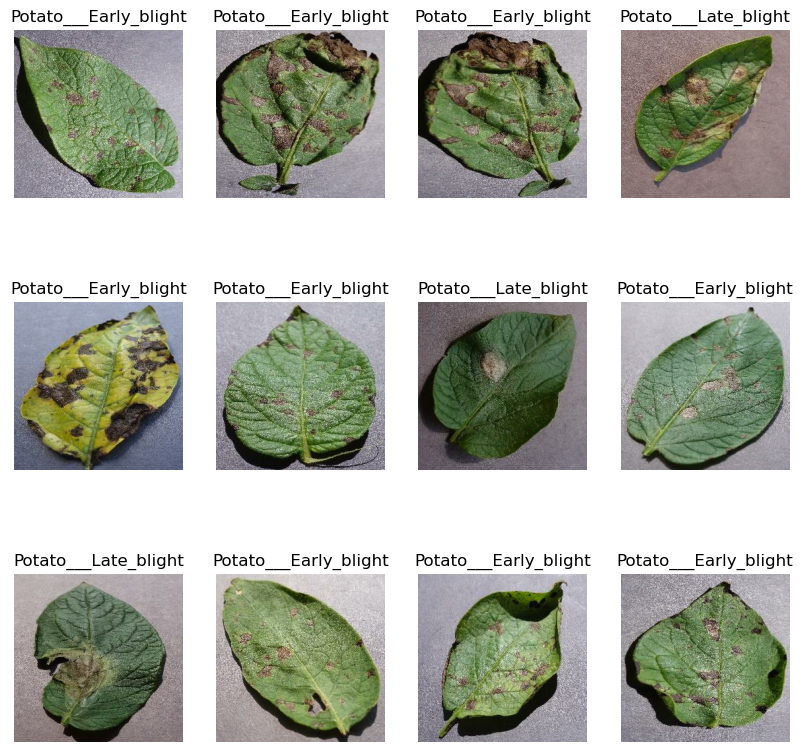

In [36]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [37]:
len(dataset)

68

In [38]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [39]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [40]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [41]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [42]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [43]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [44]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [45]:
len(train_ds)

54

In [46]:
len(val_ds)

6

In [47]:
len(test_ds)

8

In [48]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [50]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])


In [52]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [62]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

In [64]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    # Reshape image into sequence: (batch, 256, 256*3)
    layers.Reshape((IMAGE_SIZE, IMAGE_SIZE * CHANNELS)),

    # LSTM processes the image row by row
    layers.LSTM(128, return_sequences=False),

    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (32, 256, 768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (32, 128)              │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,715 (1.78 MB)

 Trainable params: 467,715 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [70]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 446ms/step - accuracy: 0.4448 - loss: 0.9738 - val_accuracy: 0.4427 - val_loss: 0.9190
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 410ms/step - accuracy: 0.5150 - loss: 0.8853 - val_accuracy: 0.4948 - val_loss: 0.8939
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 452ms/step - accuracy: 0.5136 - loss: 0.8775 - val_accuracy: 0.6250 - val_loss: 0.8588
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.5977 - loss: 0.8485 - val_accuracy: 0.6146 - val_loss: 0.8339
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 418ms/step - accuracy: 0.6536 - loss: 0.7788 - val_accuracy: 0.5990 - val_loss: 0.8354
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 448ms/step - accuracy: 0.6953 - loss: 0.7315 - val_accuracy: 0.4479 - val_loss: 0.9705
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 401ms/step - accuracy: 0.6771 - loss: 0.7579 - val_accuracy: 0.6979 - val_loss: 0.7664
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 445ms/step - accuracy: 0.6919 - loss: 0.7153 - val_accu

In [72]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.8931 - loss: 0.2918


In [75]:
scores

[0.2511622905731201, 0.91796875]

In [77]:
history

In [79]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [81]:

history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [83]:
type(history.history['loss'])

list

In [85]:
len(history.history['loss'])

50

In [87]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9225154519081116,
 0.89079350233078,
 0.8709439635276794,
 0.8257117867469788,
 0.778801441192627]

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

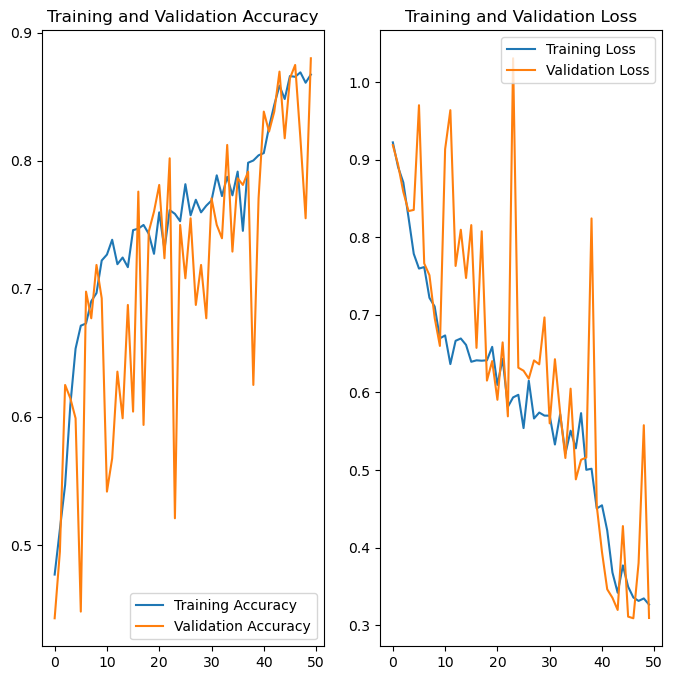

In [91]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
predicted label: Potato___Early_blight


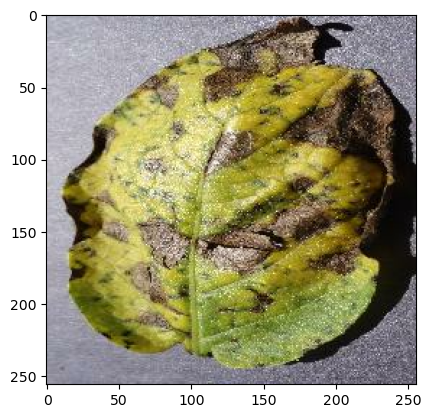

In [93]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [94]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


2025-04-13 11:42:08.234340: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


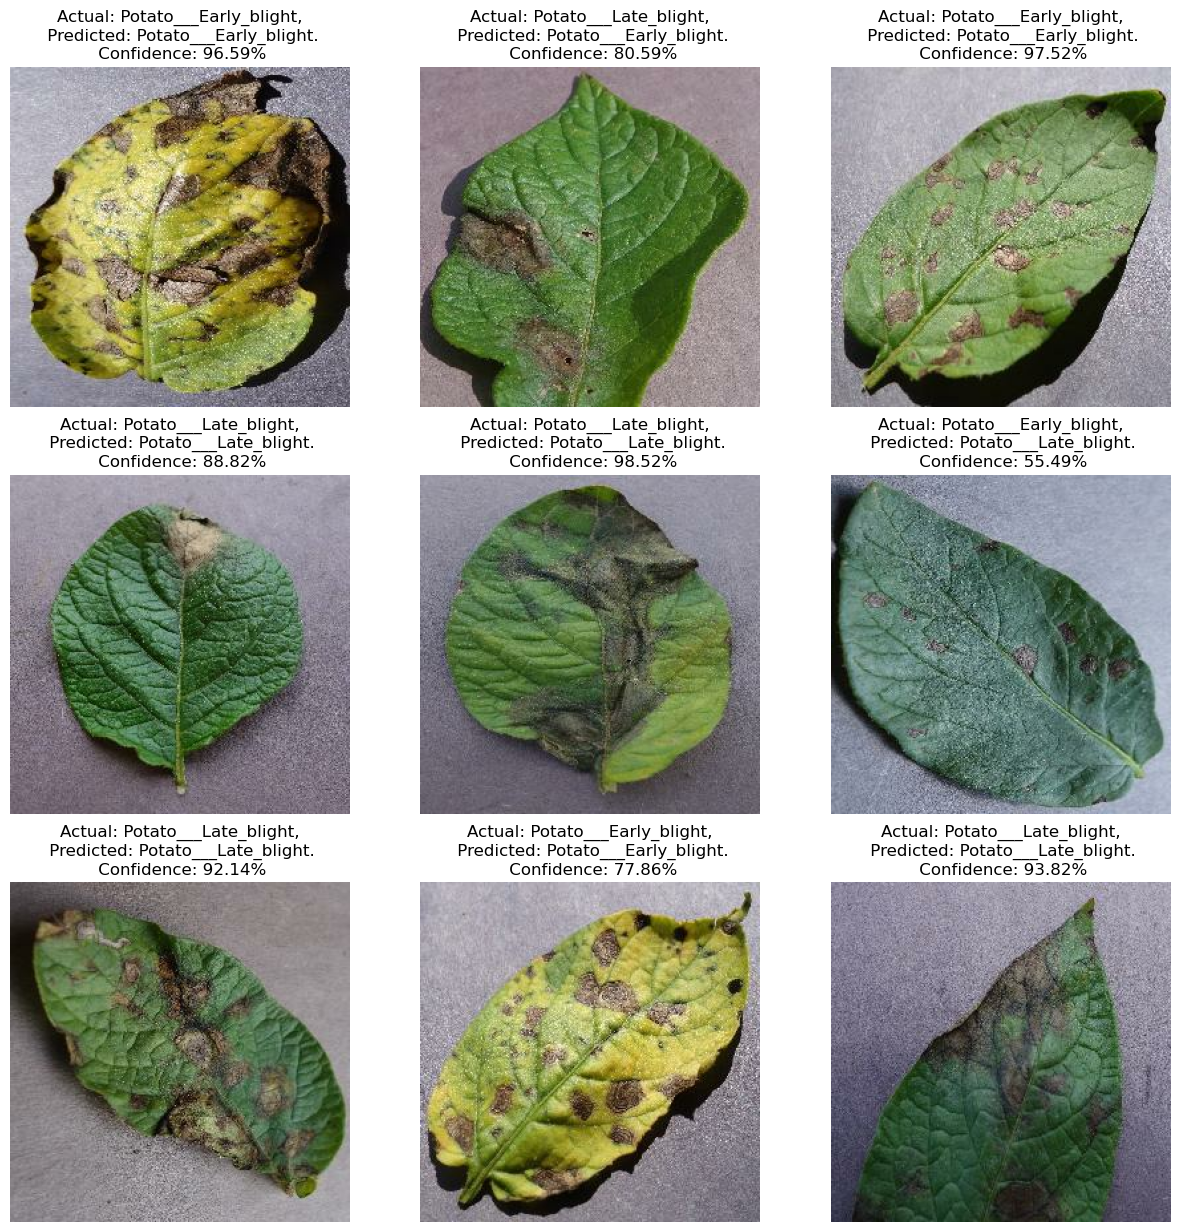

In [97]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [99]:

import os

os.makedirs("../models", exist_ok=True)

existing_versions = [int(i) for i in os.listdir("../models") if i.isdigit()]
model_version = max(existing_versions + [0]) + 1

In [101]:

model.save("../potatoes.keras")

In [103]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9155 - loss: 0.2631
Test Accuracy: 0.9180


In [105]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    preds = model.predict(images_batch)
    for i in range(3):
        actual = class_names[labels_batch[i]]
        predicted = class_names[np.argmax(preds[i])]
        print(f"Image {i+1} - Actual: {actual}, Predicted: {predicted}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Image 1 - Actual: Potato___Early_blight, Predicted: Potato___Early_blight
Image 2 - Actual: Potato___Late_blight, Predicted: Potato___Late_blight
Image 3 - Actual: Potato___Late_blight, Predicted: Potato___Late_blight


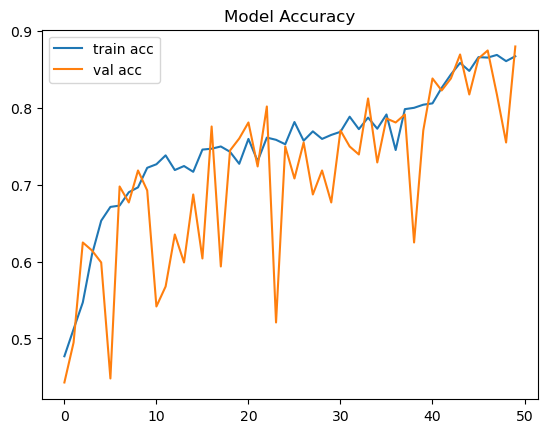

In [107]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Model Accuracy')
plt.show()